## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

In [2]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')

In [3]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)

x_t10 = copy.deepcopy(x_s)
temp_list = [0 for inner_i in range(2)]
temp_list[0] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t10))]
temp_matrix = torch.tensor(temp_matrix)
x_t10 = torch.cat([x_t10, temp_matrix], axis=1).type(torch.float32)
y_t10 = copy.deepcopy(y_s)

temp_list = [0 for inner_i in range(2)]
temp_list[1] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t))]
temp_matrix = torch.tensor(temp_matrix)
x_t = torch.cat([x_t, temp_matrix], axis=1).type(torch.float32)

temp_list = [0 for inner_i in range(2)]
temp_list[1] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t_labeled))]
temp_matrix = torch.tensor(temp_matrix)
x_t_labeled = torch.cat([x_t_labeled, temp_matrix], axis=1).type(torch.float32)

## DARC

In [11]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.fe = nn.Linear(1+(1+1), 256)
        self.mid1 = nn.Linear(256,256)
        self.mid2 = nn.Linear(256,256)
        self.mid4 = nn.Linear(256, 1)
        self.relu = nn.ReLU()


    def forward_one(self, x):
        x = self.fe(x)
        x = self.relu(x)
        x = self.mid1(x)
        x = self.relu(x)
        x = self.mid2(x)
        x = self.relu(x)
        x = self.mid4(x)
        x = self.relu(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

### Meta-Learning

In [46]:
model = Siamese()

# Set the Training Parameters
lr = 1e-3
best_model = copy.deepcopy(model)
best_loss = 10000000


optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()
# bn = 30
# total_x = x_t_labeled
# total_y = y_t_labeled

# total_x = torch.cat([total_x, x_t10],axis=0)
# total_y = torch.cat([total_y, y_t10],axis=0)

for outer_epoch in range(10000):

    
    temp_loss = 0
    for inner_epoch in range(5):
        sample = random.sample(range(len(x_t10)), len(x_t_labeled))
        total_x = x_t_labeled
        total_y = y_t_labeled

        total_x = torch.cat([total_x, x_t10[sample]],axis=0)
        total_y = torch.cat([total_y, y_t10[sample]],axis=0)
        sample1 = random.sample(range(len(total_x)), len(x_t_labeled))
        sample2 = random.sample(range(len(total_x)), len(x_t_labeled))
        
        xi = total_x[sample1]
        xj = total_x[sample2]
        yi = total_y[sample1]
        yj = total_y[sample2]

        optimizer.zero_grad()
        y_dist = torch.abs(yi - yj)
        z1,z2 = model(xi, xj)
        distance = F.pairwise_distance(z1,z2,keepdim=True)


        psp_loss = torch.square(y_dist - distance).mean()    
        psp_loss.backward()
        optimizer.step()
        temp_loss += psp_loss
            
    if outer_epoch % 100 == 99:
        print(f"epoch : {outer_epoch}, train loss : {temp_loss.detach().item()/5}")
    

epoch : 99, train loss : 0.4870323657989502
epoch : 199, train loss : 0.12639881372451783
epoch : 299, train loss : 0.13318324089050293
epoch : 399, train loss : 0.06677101254463196
epoch : 499, train loss : 0.08202970027923584
epoch : 599, train loss : 0.07011011838912964
epoch : 699, train loss : 0.039924636483192444
epoch : 799, train loss : 0.07348882555961608
epoch : 899, train loss : 0.05178656578063965
epoch : 999, train loss : 0.04650193452835083
epoch : 1099, train loss : 0.05658231377601623
epoch : 1199, train loss : 0.0711069643497467
epoch : 1299, train loss : 0.039160889387130735
epoch : 1399, train loss : 0.022642770409584047
epoch : 1499, train loss : 0.02435155212879181
epoch : 1599, train loss : 0.050630432367324826
epoch : 1699, train loss : 0.017636203765869142
epoch : 1799, train loss : 0.01917864978313446
epoch : 1899, train loss : 0.021906210482120513
epoch : 1999, train loss : 0.03380744457244873
epoch : 2099, train loss : 0.04118707478046417
epoch : 2199, train 

KeyboardInterrupt: 

### Meta-Inference

test mse : 0.0689210519194603, denoised test mse : 0.05866473540663719


c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


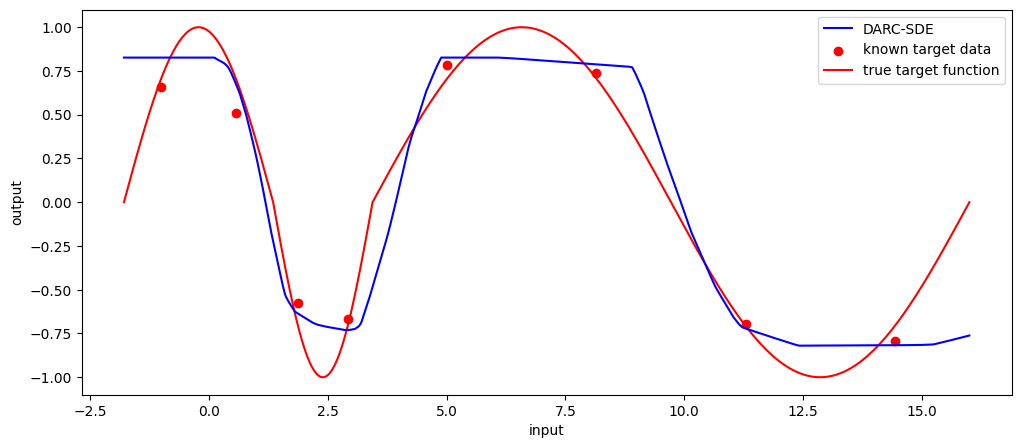

In [49]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

MLPR = MLPRegressor(hidden_layer_sizes=(30,30), validation_fraction=0.1)
latent_source_x = torch.tensor([])
latent_source_y = torch.tensor([])

latent_source_x = torch.cat([latent_source_x, model.forward(x_t10, x_t10)[0].detach()], axis=0)
latent_source_y = torch.cat([latent_source_y, y_t10], axis=0)
latent_source_x = np.array(latent_source_x)
latent_source_y = np.array(latent_source_y)
latent_target_x = model.forward(x_t, x_t)[0].detach().numpy()

MLPR.fit(latent_source_x, latent_source_y)
print(f"test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t)}, denoised test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t_true)}")

plt.figure(figsize=(12,5))
plt.plot(x_t[:,[0]], MLPR.predict(latent_target_x), c='blue', label='DARC-SDE', zorder=2)
plt.scatter(x_t_labeled[:,[0]], y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t[:,[0]], y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
